In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
# set as seaborn’s default theme
sns.set_theme()
import glob     
import numpy as np
from PIL import Image
from collections import Counter
import os
import shutil

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
from torchsummary import summary
import torch.nn as nn
from torch import optim
from sklearn.model_selection import train_test_split
import torch
# Speeds up convolutions by trying different algorithms for computing convolutions
torch.backends.cudnn.benchmark = True

# Load the data path to images
# Rmb to mount your Gdrive
IMG_DIR = '/content/drive/MyDrive/fish_are_mans_friend/data/train'

# Batch Size
BATCH_SIZE = 64

# Label Map
label_map = {
    0: "ALB",
    1: "BET",
    2: "DOL",
    3: "LAG",
    4: "NoF",
    5: "OTHER",
    6: "SHARK",
    7: "YFT",
}

# We will assume that all images are of .jpg and .png extensions

In [3]:
# Split our training dataset to train and valid
def perform_train_valid_split(train_dataset,test_size=0.3,shuffle=True):
    train, valid = train_test_split(
                                            np.arange(len(train_dataset.targets)),
                                            test_size=test_size,
                                            shuffle=shuffle
                                  )

    return train, valid

In [4]:
# For using our pre-trained model VGG16, we need to ensure that we use the exact same pre-processing steps
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]
        )

# Load the training and validation dataset
try:  
  dataset = datasets.ImageFolder(IMG_DIR, transform=transform)
  print(dataset)  
except FileNotFoundError:
  raise Exception("Try running cd train and rm -r .ipynb_checkpoints as it causing confusion https://stackoverflow.com/questions/68229246/pytorch-torchvision-datasets-imagefolder-filenotfounderror-found-no-valid-file") 

CLASSES = list(set(dataset.targets))
print([label_map[i] for i in CLASSES])

# randomly split train and validation data, we could also do a simple splice of 0.5 train - 0.5 validate.
valid_split = 0.2
data_size = len(dataset)
valid_size =  int(data_size * valid_split)
train_size =  data_size - valid_size

train_dataset, valid_dataset = random_split(dataset, [train_size,valid_size],generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, num_workers = 2, pin_memory=True)

Dataset ImageFolder
    Number of datapoints: 3777
    Root location: /content/drive/MyDrive/fish_are_mans_friend/data/train
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


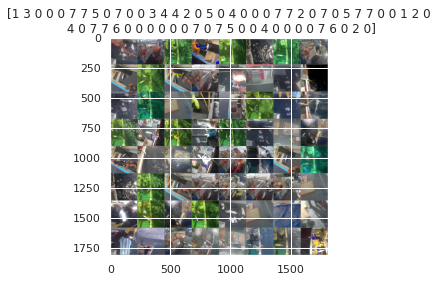

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrows=20)
imshow(out,title=classes.numpy())

In [11]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = models.resnet152(pretrained=True)
print(model_ft)

cuda


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
def weight_builder(label_map,data_size):
  weights = []
  for value in label_map.values():
    weights.append(len(glob.glob(f"{IMG_DIR}/{value}"))/data_size)
  return weights

In [13]:
  # Freeze model parameters because they were trained already
for param in model_ft.parameters():
    param.requires_grad = False

# Change the final layer of AlexNet Model for Transfer Learning
# Here the size of each output sample is set to 8
fc_inputs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(CLASSES))
)
model_ft = model_ft.to(device)
# Create weights to handle class imbalance
weights = weight_builder(label_map,data_size)
# added weights to crossentropyloss for class imbalance
loss_fn = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))
# We will use ADAM as our opitimiser
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
# Exponentially Decay LR by a factor of 0.1
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
import copy
import time
plot_train_acc = []
plot_train_loss = []
plot_val_acc = []
plot_val_loss = []
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
                dataset_size = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_dataloader
                dataset_size = valid_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double() / dataset_size
            if phase == 'train':
                plot_train_loss.append(float(epoch_loss))
                plot_train_acc.append(float(epoch_acc))
            if phase == 'val':
                plot_val_loss.append(float(epoch_loss))
                plot_val_acc.append(float(epoch_acc))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model
model_ft = train_model(model_ft, loss_fn, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4216 Acc: 0.5093
val Loss: 1.1836 Acc: 0.5722

Epoch 1/24
----------
train Loss: 1.0567 Acc: 0.6188
val Loss: 0.9478 Acc: 0.6437

Epoch 2/24
----------
train Loss: 0.8833 Acc: 0.6807
val Loss: 0.8303 Acc: 0.7126

Epoch 3/24
----------
train Loss: 0.7732 Acc: 0.7280
val Loss: 0.7192 Acc: 0.7669

Epoch 4/24
----------
train Loss: 0.6856 Acc: 0.7608
val Loss: 0.6982 Acc: 0.7682

Epoch 5/24
----------
train Loss: 0.6207 Acc: 0.7839
val Loss: 0.6261 Acc: 0.7947

Epoch 6/24
----------
train Loss: 0.5801 Acc: 0.7929
val Loss: 0.6048 Acc: 0.7921

Epoch 7/24
----------
train Loss: 0.4960 Acc: 0.8336
val Loss: 0.5470 Acc: 0.8146

Epoch 8/24
----------
train Loss: 0.4695 Acc: 0.8475
val Loss: 0.5386 Acc: 0.8185

Epoch 9/24
----------
train Loss: 0.4577 Acc: 0.8484
val Loss: 0.5333 Acc: 0.8212

Epoch 10/24
----------
train Loss: 0.4536 Acc: 0.8531
val Loss: 0.5297 Acc: 0.8225

Epoch 11/24
----------
train Loss: 0.4460 Acc: 0.8504
val Loss: 0.5263 Acc: 0.8238

Ep

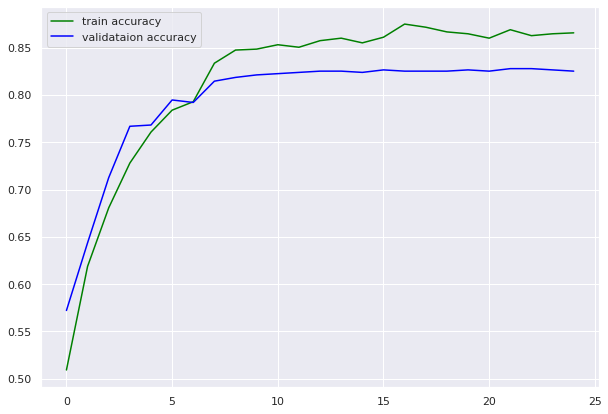

In [15]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_acc, color='green', label='train accuracy')
plt.plot(plot_val_acc, color='blue', label='validataion accuracy')
plt.legend()
# plt.savefig('../images/train_val_accuracy.png')
plt.show()

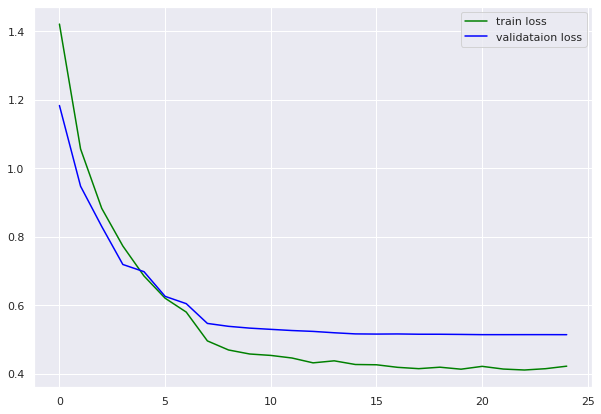

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(plot_train_loss, color='green', label='train loss')
plt.plot(plot_val_loss, color='blue', label='validataion loss')
plt.legend()
# plt.savefig('/content/drive/MyDrive/fish_are_mans_friend/qy_images/train_val_loss.png')
plt.show()

In [18]:
torch.save(model_ft,'resnet152_v1_25_0.828.pt')